In [172]:
import scanpy as sc
import numpy as np
import scipy as sp
from scipy.stats import spearmanr, pearsonr, wilcoxon

import pandas as pd

In [157]:
# Importing plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from matplotlib import cm

sns.set_style('ticks', {'font.family': 'FreeSans'})

In [3]:
# Scanpy settings
sc.settings.verbosity = 3            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

#celltype = 'all'
master_dir = '../'

-----
anndata     0.7.5
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 8.0.1
anndata             0.7.5
backcall            0.2.0
cffi                1.14.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
igraph              0.8.3
ipykernel           5.3.4
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.17.2
joblib              0.14.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.34.0
louvain             0.7.0
matplotlib          3.3.3
mpl_toolkits        NA
natsort             7.1.0
netifaces           0.10.9
numba               0.51.2
numexpr             2.7.1
numpy               1.19.4
packaging           20.4
pandas              1.1.4
parso               0.7.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.8
psutil              5.7.0
ptyp

In [4]:
# Get the dictionary associating pathway names with metabolic classifications
classifications = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg-KEGGclassified.gmt', 
                              header=None, sep='\t')
classifications.index = classifications[0]
classifications = classifications.drop(columns=[0])
classifications.columns = ['classification']
classifications = classifications.to_dict()['classification']

In [5]:
adata_metab = sc.read_h5ad(master_dir + 'output/disease_comparisons/disease-comparison-metab.h5ad')
adata = sc.read_h5ad(master_dir + 'data/PBMC_processed/disease_comparisons/normalized_MAGIC_ALL_CD8_T.h5ad')
adata_metab

AnnData object with n_obs × n_vars = 37796 × 1121
    obs: 'Age_at_baseline', 'Blood_draw_time', 'CellID', 'Days_since_onset_of_symptoms', 'ICU_status', 'IL6i_between_draws', 'Sex', 'TimePoint', 'WHO_scale', 'batch_info', 'biosample_id', 'cell_groups', 'cell_state', 'cell_type', 'cell_type__ontology_label', 'disease', 'disease__ontology_label', 'donor_id', 'end_bias', 'enrichment__cell_type', 'enrichment__cell_type__ontology_label', 'enrichment__facs_markers', 'enrichment_method', 'geographical_region', 'geographical_region__ontology_label', 'is_living', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'nGene', 'nUMI', 'n_counts', 'no_IL6i', 'organ', 'organ__ontology_label', 'organism_age', 'organism_age__unit', 'organism_age__unit_label', 'paired_ends', 'patient', 'percent_mito', 'pheno', 'read_length', 'sample_type', 'sequencing_instrument_manufacturer_model', 'sequencing_instrument_manufacturer_model__ontology_label', 'sex', 'sort', 'species', 'species

In [6]:
# Loading in metabolics-relevant pathways from KEGG (based on Xiao et al. Nat Commun 2019)
#metab_pathway_list = pd.read_csv(master_dir + 'data/MSigDB/KEGG_metab_pathway_list_Xiao2019-JLmod200620.txt', 
#                                 sep='\t', header=None)
#metab_pathway_list = np.array(metab_pathway_list.iloc[:, 0])

# Genes in each KEGG pathway
metab_genes = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg.gmt', 
                          sep='\t', header=None)
metab_genes.index = metab_genes.iloc[:, 0]
metab_genes = metab_genes.drop([0], axis=1)
# Drop the following pathways because none of the genes are found in the preprocessed adata
metab_genes = metab_genes.drop(index=['C5-Branched dibasic acid metabolism',
                                     'Lysine biosynthesis', 
                                     'D-Arginine and D-ornithine metabolism',
                                     'Polyketide sugar unit biosynthesis', 
                                     'Biosynthesis of vancomycin group antibiotics', 
                                     'Penicillin and cephalosporin biosynthesis'])

metab_pathway_list = metab_genes.index
metab_genes.head()

,1,2,3,4,5,6,7,8,9,10,...,124,125,126,127,128,129,130,131,132,133
0,,,,,,,,,,,,,,,,,,,,,
Glycolysis / Gluconeogenesis,LDHC,HK3,LDHB,PFKP,ALDOA,ALDOB,ADH6,GAPDHS,DLAT,PGM1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Citrate cycle (TCA cycle),DLST,ACO1,CS,IDH3B,ACLY,SUCLG2,DLAT,IDH3A,SUCLA2,PDHB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pentose phosphate pathway,PFKP,ALDOA,RPIA,ALDOB,H6PD,RPE,RPEL1,PRPS1L1,PFKM,RBKS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pentose and glucuronate interconversions,UGT2B4,UGT2A1,XYLB,CRYL1,UGT2B17,UGT1A3,UGDH,UGT1A4,UGT1A8,UGP2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fructose and mannose metabolism,HK3,PFKFB3,PFKP,FCSK,ALDOA,ALDOB,GFUS,TPI1,PMM2,SORD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Convert the metabolic pathways dataframe into a dictionary for GSEA
metab_genes_dict = metab_genes.transpose().to_dict(orient='series')
for element in metab_genes_dict:
    # Only include the genes that are also found in the single cell sequencing
    metab_genes_dict[element] = list(set(metab_genes_dict[element]).intersection(set(adata.var_names)))

In [8]:
# Also get a flat array of metabolism-related genes
metab_gene_list = []
for geneset in metab_genes_dict.values():
    for gene in geneset:
        metab_gene_list.append(gene)
metab_gene_list = np.array(metab_gene_list)
len(metab_gene_list)

1913

# Pathway activity analysis 
Modeled after Xiao et al. <i>Nat Commun</i> (2019) Fig. 2

For the i-th metabolic gene, the <u>mean expression level</u> across cells of the j-th cell type is

$E_{i,j} = \frac{\sum_{k=1}^{n_j} g_{i,k}}{n_j}, i \in 1 ... M, j \in 1 ... N $

in which $n_j$ is the number of cells in the j-th cell type, $g_{i,k}$ is the expression level of the i-th gene in the k-th cell in this cell type, M is the number of metabolic genes, and N is the number of cell types.

<u>Relative expression level</u> of gene i in cell type j is

$r_{i,j} = \frac{E_{i,j}}{1/N \sum_j^N E_{i,j}}$

Exclude genes with low expression level or high dropout rate:

Exclude outliers in each pathway defined by genes with relative expression levels >3 x 75th percentile expression or <1/3 x 25th percentile

<u>Pathway activity score for the t-th pathway and the j-th cell type is the weighted average of $r_{i,j}$ over all genes included in this pathway:</u>

$p_{t,j} = \frac{\sum_{i=1}^{m_t} w_i \times r_{i,j}}{\sum_{i=1}^{m_t} w_i}$

where $m_t$ is the number of genes in the pathway t, $w_i$ is the weighting factor equal to the reciprocal of the number of pathways that include the i-th gene.

In [9]:
pathways = [list(genes) for genes in list(metab_genes_dict.values())]

# wi is the reciprocal of the number of pathways that include the ith gene,
# summarized in array w
w = [[pathway.count(gene) / list(metab_gene_list).count(gene) for gene 
      in adata_metab.var_names.values] for pathway in pathways]

In [10]:
# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
def pathway_activity(data, data_metab, cluster_label, print_labels=False, nanval=0, exclude_clusters=[]):
    cluster_ids = list(data.obs[cluster_label].unique())
    cluster_ids.sort()
    
    for cluster_id in exclude_clusters:
        cluster_ids.remove(cluster_id)
        
    mel = np.zeros([len(cluster_ids), len(data_metab.X[0])])
    for i, cluster_id in enumerate(cluster_ids):
        if print_labels:
            print(cluster_id)
        cluster = data_metab[data.obs[cluster_label]==cluster_id]
        g = cluster.X # Matrix of gene expression of ith gene in the kth cell of this cluster (cell type)
        n = len(cluster) # Number of cells in the cluster (cell type)
        # Calculate mean expression level
        mel[i] = np.sum(g, axis=0) / n # Sum gene expressions per gene across all cells in this cluster (cell type),
            # divided by number of cells in the cluster (cell type)        

    # Remove genes that are 0 in any cluster to avoid extreme ratio value
    mel = np.array(mel)
    m = min(mel[mel > 0])
    mel[mel==0] = m
            
    # Calculate relative expression level of each gene
    rel = mel / (np.sum(mel, axis=0) / len(mel))

    # Filtering
    lowExpr, highExpr = np.percentile(rel, [25, 75], axis=None) 
    
    tooHigh = (rel > 3 * highExpr) * rel
    tooLow = (rel < lowExpr / 3) * rel
    
    rel -= tooHigh
    rel -= tooLow
    rel = np.nan_to_num(rel, nan=nanval)
    
    # Calculate the pathway activity score
    # Pathway activity matrix
    # Each row is a pathway, each column is a cluster
    p = np.array([np.sum(w * rel[j], axis=1) / np.sum(w, axis=1) for j in range(len(rel))]).transpose()
    
    # Remove nan values
    p = np.nan_to_num(p, nan=1)
    
    return p

In [15]:
adata.obs['disease_state'].unique()

['Control', 'COVID-19', 'Hyperacute HIV', 'Bacterial Sepsis']
Categories (4, object): ['Control', 'COVID-19', 'Hyperacute HIV', 'Bacterial Sepsis']

In [16]:
adata.obs['cell_type'].unique()

['Non PE T-cells', 'Non T-cells', 'PE T-cells', 'Unconfident PE T-cells']
Categories (4, object): ['Non PE T-cells', 'Non T-cells', 'PE T-cells', 'Unconfident PE T-cells']

In [22]:
adata.obs['cell_type_per_dz'] = adata.obs['cell_type'].astype(str) + ' of ' + adata.obs['disease_state'].astype(str)
adata_metab.obs['cell_type_per_dz'] = adata_metab.obs['cell_type'].astype(str) + \
                ' of ' + adata_metab.obs['disease_state'].astype(str)

In [23]:
adata.obs['cell_type_per_dz'].unique()

array(['Non PE T-cells of Control', 'Non T-cells of Control',
       'Non PE T-cells of COVID-19', 'Non T-cells of COVID-19',
       'PE T-cells of COVID-19', 'Unconfident PE T-cells of COVID-19',
       'PE T-cells of Control', 'Non PE T-cells of Hyperacute HIV',
       'PE T-cells of Hyperacute HIV',
       'Unconfident PE T-cells of Hyperacute HIV',
       'Unconfident PE T-cells of Control',
       'Non PE T-cells of Bacterial Sepsis',
       'PE T-cells of Bacterial Sepsis',
       'Unconfident PE T-cells of Bacterial Sepsis'], dtype=object)

<AxesSubplot:>

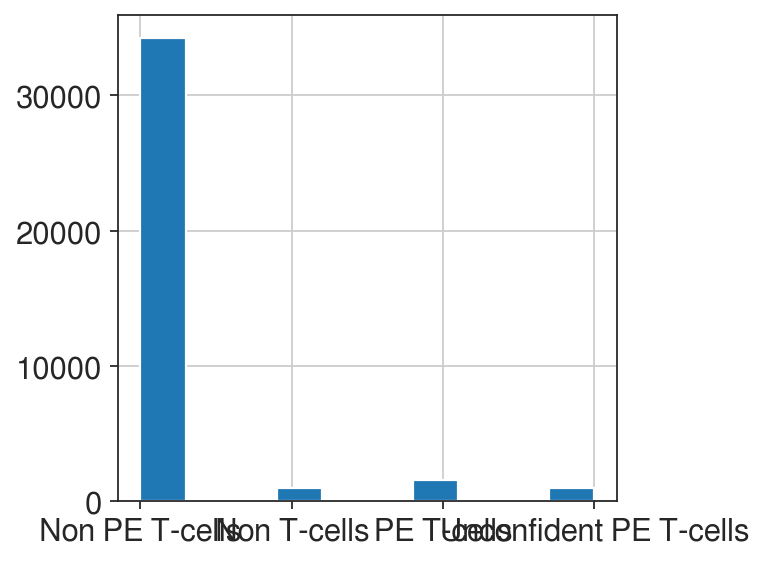

In [158]:
adata.obs['cell_type'].hist()

<AxesSubplot:>

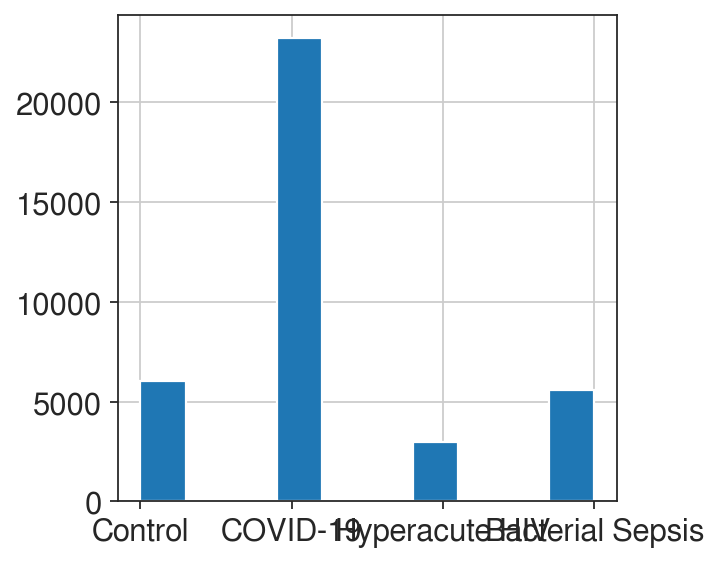

In [159]:
adata.obs['disease_state'].hist()

## Pathway activity analysis between cell types

In [31]:
p = pathway_activity(adata, adata_metab, 'cell_type_per_dz', print_labels=True,
                    exclude_clusters=['Non PE T-cells of Control', 'Non T-cells of Control',
                    'Non T-cells of COVID-19', 'Unconfident PE T-cells of COVID-19',
                    'PE T-cells of Control', 'Unconfident PE T-cells of Hyperacute HIV',
                    'Unconfident PE T-cells of Control', 'Unconfident PE T-cells of Bacterial Sepsis'])

Non PE T-cells of Bacterial Sepsis
Non PE T-cells of COVID-19
Non PE T-cells of Hyperacute HIV
PE T-cells of Bacterial Sepsis
PE T-cells of COVID-19
PE T-cells of Hyperacute HIV


Calculate <u>statistical significance</u>: random permutation test
1. Randomly shuffle cell type labels 5,000 times to simulate null distribution of pathway activity scores
2. Compare to the pathway activity scores in the original, non-shuffled dataset
3. p-value = fraction of random pathway activity scores 
    - $> p_{t,j}$ if $p_{t,j} > 1$, meaning that pathway activity is significantly higher 
    - $< p_{t,j}$ if $p_{t,j} < 1$, meaning that pathway activity is significantly lower

In [43]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 1000x
n = 1000
compares = np.zeros((len(p), len(p[0])))

# Declare relevant variables before for loop to prevent memory leaks
obs_name = 'cell_type_per_dz'

# Shuffle cell cluster labels 1000x
data = adata[~adata.obs[obs_name].isin(['Non PE T-cells of Control', 'Non T-cells of Control',
                    'Non T-cells of COVID-19', 'Unconfident PE T-cells of COVID-19',
                    'PE T-cells of Control', 'Unconfident PE T-cells of Hyperacute HIV',
                    'Unconfident PE T-cells of Control', 'Unconfident PE T-cells of Bacterial Sepsis'])]
data_metab = adata_metab[data.obs[obs_name].index]

data.obs[obs_name + '_shuffle'] = pd.Series()
data_metab.obs[obs_name + '_shuffle'] = pd.Series()
clusters_shuffled = np.zeros(len(data.obs))
p_shuffle = np.zeros([len(w), len(data.obs[obs_name].unique())])

for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs[obs_name])
    data.obs[obs_name + '_shuffle'] = clusters_shuffled
    data_metab.obs[obs_name + '_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, obs_name + '_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

<ipython-input-43-23b7f159e0a2>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data.obs[obs_name + '_shuffle'] = pd.Series()
Trying to set attribute `.obs` of view, copying.
<ipython-input-43-23b7f159e0a2>:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data_metab.obs[obs_name + '_shuffle'] = pd.Series()
Trying to set attribute `.obs` of view, copying.


0
100
200
300
400
500
600
700
800
900


In [44]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

In [45]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/disease_comparisons/' + obs_name + '-metab-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)
# Read saved pathway activity scores
df_p = pd.read_csv(master_dir + 'output/disease_comparisons/' + obs_name + '-metab-pathway_activity.tabular', 
                   sep='\t', header=None)
df_p.head()

,0,1,2,3,4,5
0,0.591916,0.661438,0.444509,1.636662,1.878926,0.780260
1,0.406755,0.540637,0.295588,1.755703,2.115645,0.869879
2,0.516181,0.720223,0.345760,1.584282,2.081741,0.747583
3,0.389100,0.519907,0.251959,1.770537,2.143163,0.743389
4,0.662154,0.640632,0.505435,1.471069,2.028627,0.686747


<ipython-input-248-20223066ccc6>:8: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0), row_cluster=False, col_cluster=False, figsize=(3, 10))


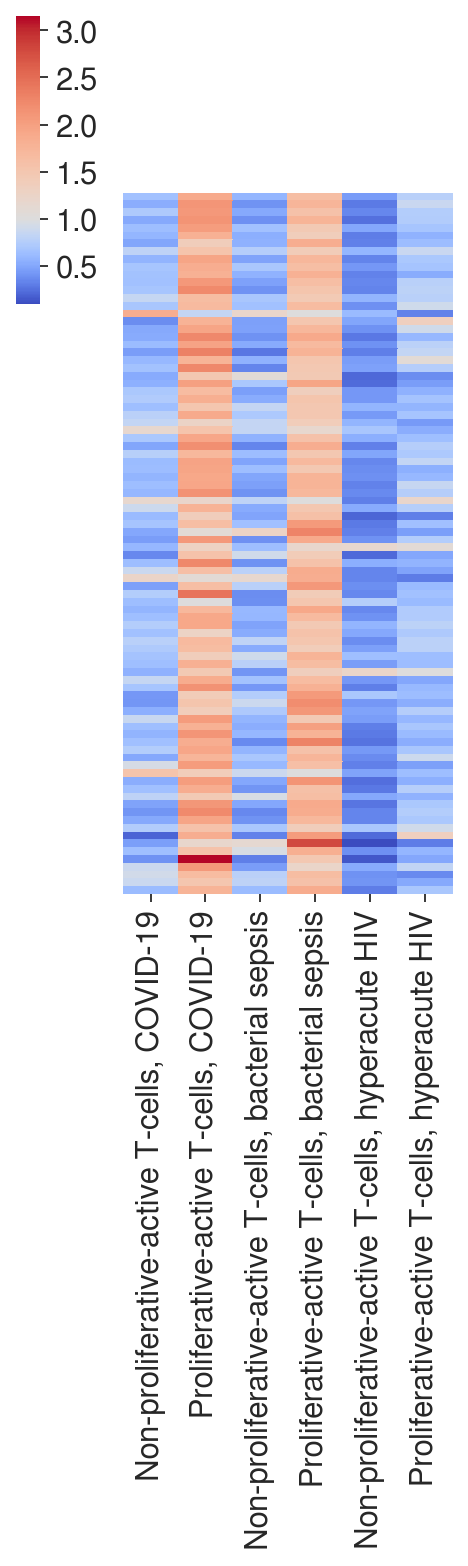

In [248]:
fig = sns.clustermap(df_p.loc[:, [1, 4, 0, 3, 2, 5]], cmap='coolwarm', 
                     xticklabels=pd.Series(['Non-proliferative-active T-cells, bacterial sepsis',
        'Non-proliferative-active T-cells, COVID-19', 'Non-proliferative-active T-cells, hyperacute HIV', 
                                            'Proliferative-active T-cells, bacterial sepsis',
            'Proliferative-active T-cells, COVID-19', 
            'Proliferative-active T-cells, hyperacute HIV']).iloc[[1, 4, 0, 3, 2, 5]], 
                     yticklabels=[], #yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), row_cluster=False, col_cluster=False, figsize=(3, 10))
plt.savefig(master_dir + 'output/disease_comparisons/metab-pathways-per-dz_heatmap.pdf')

## Venn diagrams of differential metabolic gene expression or metabolic pathway activities
### Gene expression-based


In [55]:
metab_genes.index

Index(['Glycolysis / Gluconeogenesis', 'Citrate cycle (TCA cycle)',
       'Pentose phosphate pathway', 'Pentose and glucuronate interconversions',
       'Fructose and mannose metabolism', 'Galactose metabolism',
       'Ascorbate and aldarate metabolism', 'Starch and sucrose metabolism',
       'Amino sugar and nucleotide sugar metabolism', 'Pyruvate metabolism',
       'Glyoxylate and dicarboxylate metabolism', 'Propanoate metabolism',
       'Butanoate metabolism', 'Inositol phosphate metabolism',
       'Oxidative phosphorylation', 'Nitrogen metabolism', 'Sulfur metabolism',
       'Fatty acid biosynthesis', 'Fatty acid elongation',
       'Fatty acid degradation', 'Synthesis and degradation of ketone bodies',
       'Cutin, suberine and wax biosynthesis', 'Steroid biosynthesis',
       'Primary bile acid biosynthesis', 'Steroid hormone biosynthesis',
       'Glycerolipid metabolism', 'Glycerophospholipid metabolism',
       'Ether lipid metabolism', 'Sphingolipid metabolism',
   

In [57]:
from matplotlib_venn import venn3, venn3_circles

In [161]:
# Get list of differentially expressed metabolic pathways and genes among the PE groups in each disease
# PE groups only
data = adata[adata.obs[obs_name].isin(['PE T-cells of COVID-19', 'PE T-cells of Bacterial Sepsis',
                                      'PE T-cells of Hyperacute HIV'])]
data_metab = adata_metab[data.obs[obs_name].index]

sc.tl.rank_genes_groups(data_metab, groupby=obs_name, n_genes=len(data_metab.var), 
                        key_added='rank_genes_groups')
sc.tl.rank_genes_groups(data_metab, groupby=obs_name, n_genes=len(data_metab.var), 
                        reference='PE T-cells of COVID-19', key_added='rank_genes_groups_vs_COVID')
sc.tl.rank_genes_groups(data_metab, groupby=obs_name, n_genes=len(data_metab.var), 
                        reference='PE T-cells of Hyperacute HIV', key_added='rank_genes_groups_vs_HIV')
sc.tl.rank_genes_groups(data_metab, groupby=obs_name, n_genes=len(data_metab.var), 
                        reference='PE T-cells of Bacterial Sepsis', key_added='rank_genes_groups_vs_sepsis')

ranking genes


/home/jwlee/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_per_dz' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_shuffle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_per_dz_shuffle' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups_vs_COVID']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups_vs_HIV']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be

In [162]:
a = sc.get.rank_genes_groups_df(data_metab, 'PE T-cells of COVID-19', 
                                pval_cutoff=0.05, key='rank_genes_groups')['names']
b = sc.get.rank_genes_groups_df(data_metab, 'PE T-cells of Bacterial Sepsis', 
                                pval_cutoff=0.05, key='rank_genes_groups')['names']
c = sc.get.rank_genes_groups_df(data_metab, 'PE T-cells of Hyperacute HIV', 
                                pval_cutoff=0.05, key='rank_genes_groups')['names']

d = set(a).intersection(set(b))
e = set(b).intersection(set(c))
f = set(c).intersection(set(a))
g = d.intersection(set(c))


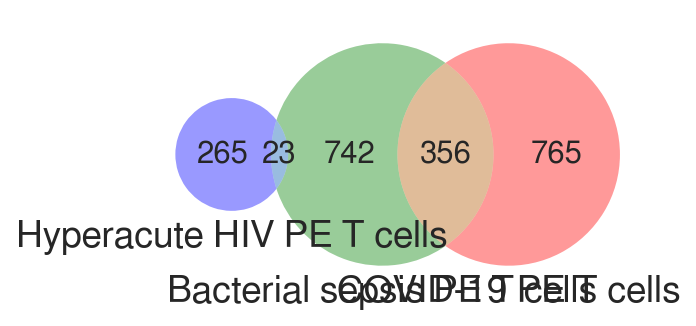

In [163]:
venn3(subsets = [set(a), set(b), set(c)], set_labels = ('COVID-19 PE T cells', 
                                                        'Bacterial sepsis PE T cells', 'Hyperacute HIV PE T cells'))

In [200]:
# Another Venn diagram with overlaps of upregulated genes in each PE group vs. non-PE group of the same disease

# Get list of differentially expressed metabolic pathways and genes among the PE groups in each disease
# PE groups only
data = adata[adata.obs[obs_name].isin(['Non PE T-cells of Bacterial Sepsis',
        'Non PE T-cells of COVID-19', 'Non PE T-cells of Hyperacute HIV', 'PE T-cells of Bacterial Sepsis',
        'PE T-cells of COVID-19', 'PE T-cells of Hyperacute HIV'])]
data_metab = adata_metab[data.obs[obs_name].index]

sc.tl.rank_genes_groups(data_metab, groupby=obs_name, n_genes=len(data_metab.var), 
                        reference='Non PE T-cells of COVID-19', key_added='rank_genes_groups_COVID')
sc.tl.rank_genes_groups(data_metab, groupby=obs_name, n_genes=len(data_metab.var), 
                        reference='Non PE T-cells of Hyperacute HIV', key_added='rank_genes_groups_HIV')
sc.tl.rank_genes_groups(data_metab, groupby=obs_name, n_genes=len(data_metab.var), 
                        reference='Non PE T-cells of Bacterial Sepsis', key_added='rank_genes_groups_sepsis')

ranking genes


/home/jwlee/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_per_dz' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_shuffle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_per_dz_shuffle' as categorical


    finished: added to `.uns['rank_genes_groups_COVID']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups_HIV']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups_sepsis']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to b

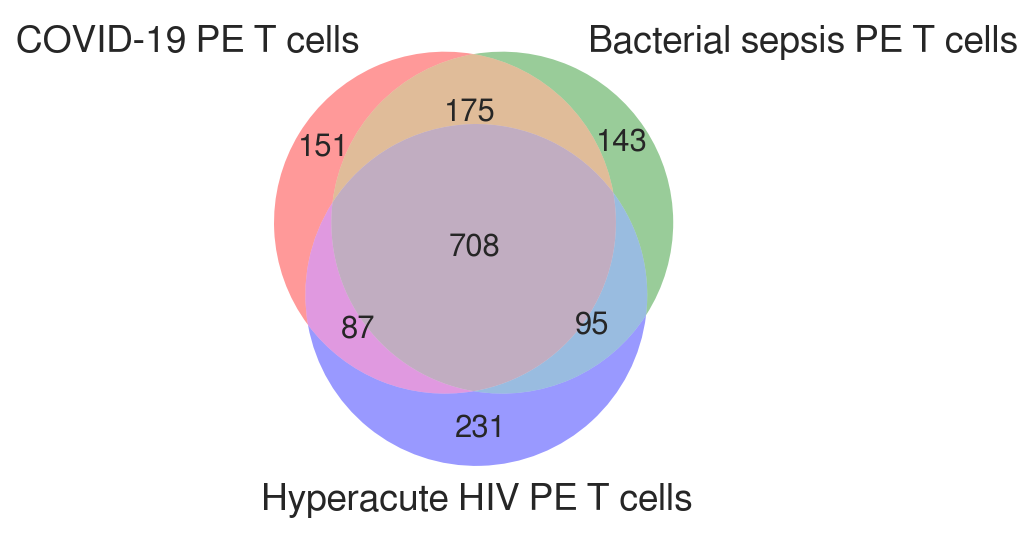

In [246]:
a = sc.get.rank_genes_groups_df(data_metab, 'PE T-cells of COVID-19', 
                                pval_cutoff=0.05, key='rank_genes_groups_COVID')['names']
b = sc.get.rank_genes_groups_df(data_metab, 'PE T-cells of Bacterial Sepsis', 
                                pval_cutoff=0.05, key='rank_genes_groups_sepsis')['names']
c = sc.get.rank_genes_groups_df(data_metab, 'PE T-cells of Hyperacute HIV', 
                                pval_cutoff=0.05, key='rank_genes_groups_HIV')['names']

d = set(a).intersection(set(b))
e = set(b).intersection(set(c))
f = set(c).intersection(set(a))
g = d.intersection(set(c))

venn3(subsets = [set(a), set(b), set(c)], set_labels = ('COVID-19 PE T cells', 
                                                        'Bacterial sepsis PE T cells', 
                                                        'Hyperacute HIV PE T cells'))
plt.savefig(master_dir + 'output/disease_comparisons/gex_high_vs_non-PE/venn.pdf')

In [247]:
diseases = ['COVID', 'Sepsis', 'HIV', 'COVID and sepsis', 'Sepsis and HIV', 'COVID and HIV', 'All']
ai = set(a).difference(set(b)).difference(set(c))
bi = set(b).difference(set(a)).difference(set(c))
ci = set(c).difference(set(b)).difference(set(a))
di = d.difference(g)
ei = e.difference(g)
fi = f.difference(g)

# Save the lists of these genes
for i, gene_list in enumerate([ai, bi, ci, di, ei, fi, g]):
    f = open(master_dir + 'output/disease_comparisons/gex_high_vs_non-PE/' + diseases[i] + '.txt', 'w')
    for j in gene_list:
        f.write(j + '\n')
    f.close()

In [244]:
len(fi)

87

### Metabolic pathway-based

In [166]:
df_metab_pathways = df_p.loc[:, [1, 4, 0, 3, 2, 5]]
df_metab_pathways.index = metab_genes.index
df_metab_pathways.columns = pd.Series(['Non PE T-cells of Bacterial Sepsis',
'Non PE T-cells of COVID-19', 'Non PE T-cells of Hyperacute HIV', 'PE T-cells of Bacterial Sepsis',
'PE T-cells of COVID-19', 'PE T-cells of Hyperacute HIV']).iloc[[1, 4, 0, 3, 2, 5]]

adata_metab_pathways = sc.AnnData(df_p.loc[:, [1, 4, 0, 3, 2, 5]].transpose())
adata_metab_pathways.var = pd.DataFrame(metab_genes.index.values).set_index(metab_genes.index.values)
adata_metab_pathways.obs = pd.DataFrame({obs_name : pd.Series(['Non PE T-cells of Bacterial Sepsis',
'Non PE T-cells of COVID-19', 'Non PE T-cells of Hyperacute HIV', 'PE T-cells of Bacterial Sepsis',
'PE T-cells of COVID-19', 'PE T-cells of Hyperacute HIV']).iloc[[1, 4, 0, 3, 2, 5]]})
adata_metab_pathways.obs[obs_name] = adata_metab_pathways.obs[obs_name].astype('category')

/home/jwlee/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([1, 4], dtype='int64'), …


/home/jwlee/.local/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


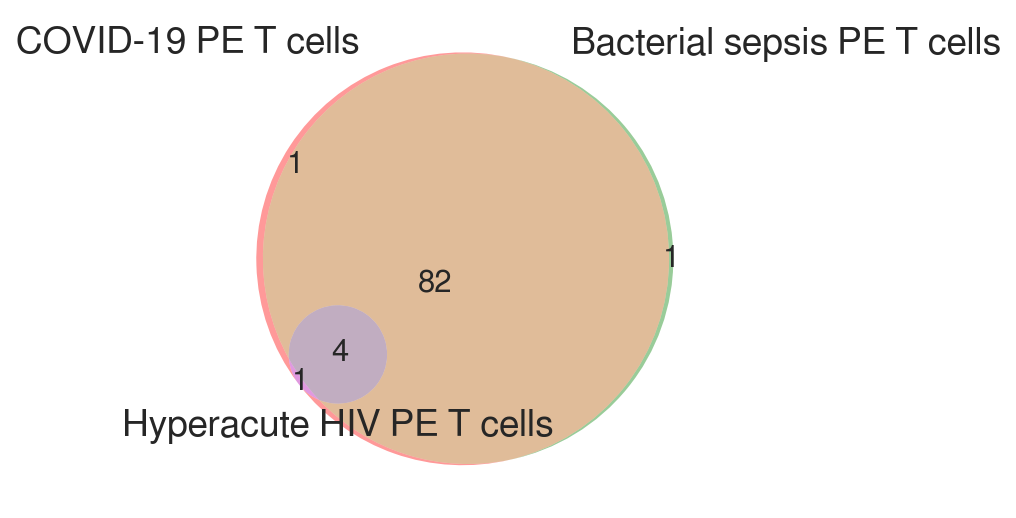

In [167]:
a = df_metab_pathways[df_metab_pathways['PE T-cells of COVID-19'] > 1.0].index.values
b = df_metab_pathways[df_metab_pathways['PE T-cells of Bacterial Sepsis'] > 1.0].index.values
c = df_metab_pathways[df_metab_pathways['PE T-cells of Hyperacute HIV'] > 1.0].index.values

venn3(subsets = [set(a), set(b), set(c)], set_labels = ('COVID-19 PE T cells', 
                                                        'Bacterial sepsis PE T cells', 
                                                        'Hyperacute HIV PE T cells'))

/home/jwlee/.local/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


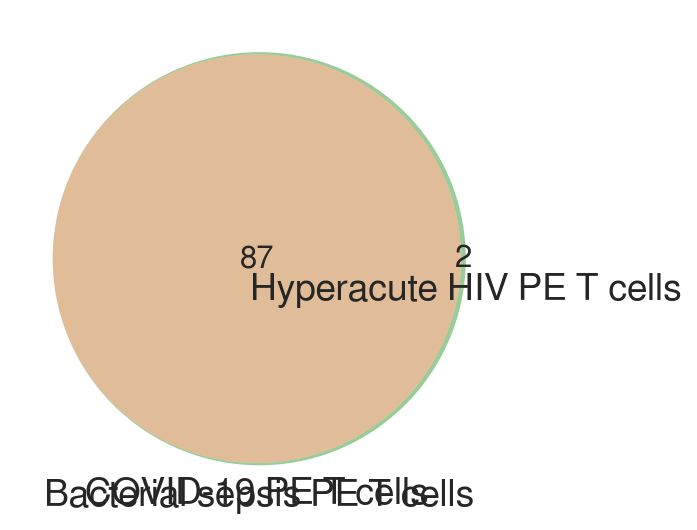

In [168]:
a = df_metab_pathways[df_metab_pathways['PE T-cells of COVID-19'] > df_metab_pathways['Non PE T-cells of COVID-19']].index.values
b = df_metab_pathways[df_metab_pathways['PE T-cells of Bacterial Sepsis'] > df_metab_pathways['Non PE T-cells of Bacterial Sepsis']].index.values
c = df_metab_pathways[df_metab_pathways['PE T-cells of Hyperacute HIV'] > df_metab_pathways['PE T-cells of Hyperacute HIV']].index.values

venn3(subsets = [set(a), set(b), set(c)], set_labels = ('COVID-19 PE T cells', 
                                                        'Bacterial sepsis PE T cells', 
                                                        'Hyperacute HIV PE T cells'))

## Box plot of metabolic pathway activities per cell group

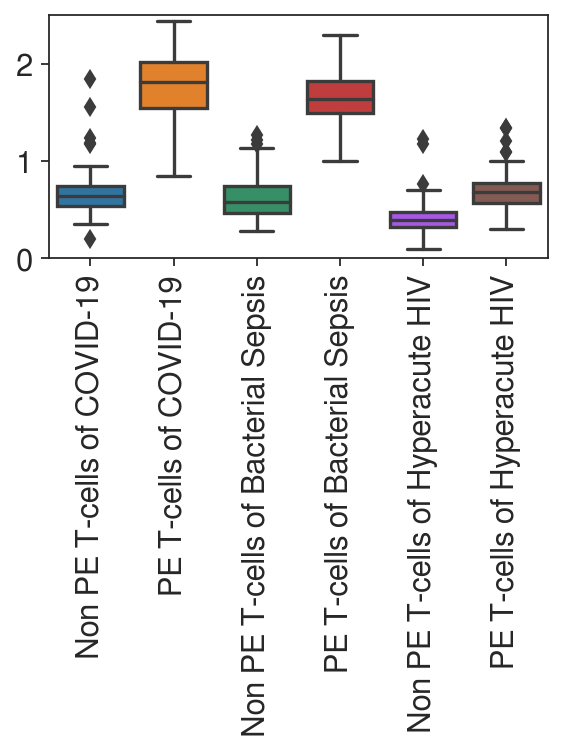

In [205]:
f = plt.figure(figsize=(4, 2))
f = sns.boxplot(x=np.repeat(df_metab_pathways.columns.values, 90), 
            y=np.array(df_metab_pathways.transpose()).flatten())
f.set_xticklabels(labels=df_metab_pathways.columns.values, rotation=90)
f.set_ylim([0, 2.5])
plt.savefig(master_dir + 'output/disease_comparisons/metab-pathways-per-dz.pdf')

In [181]:
temp = df_metab_pathways.columns.copy()
for i in temp:
    temp = temp.drop(i)
    for j in temp:
        print('\n', i, 'vs', j, ':', wilcoxon(df_metab_pathways[i], df_metab_pathways[j]).pvalue)


 Non PE T-cells of COVID-19 vs PE T-cells of COVID-19 : 6.393352900641364e-16

 Non PE T-cells of COVID-19 vs Non PE T-cells of Bacterial Sepsis : 0.0006212864266172516

 Non PE T-cells of COVID-19 vs PE T-cells of Bacterial Sepsis : 6.185757131825867e-16

 Non PE T-cells of COVID-19 vs Non PE T-cells of Hyperacute HIV : 4.0854723615352513e-13

 Non PE T-cells of COVID-19 vs PE T-cells of Hyperacute HIV : 0.18624083186800322

 PE T-cells of COVID-19 vs Non PE T-cells of Bacterial Sepsis : 2.358513121489771e-16

 PE T-cells of COVID-19 vs PE T-cells of Bacterial Sepsis : 0.0011740732138610431

 PE T-cells of COVID-19 vs Non PE T-cells of Hyperacute HIV : 1.7437900167092118e-16

 PE T-cells of COVID-19 vs PE T-cells of Hyperacute HIV : 1.7437900167092118e-16

 Non PE T-cells of Bacterial Sepsis vs PE T-cells of Bacterial Sepsis : 1.9287294406628382e-16

 Non PE T-cells of Bacterial Sepsis vs Non PE T-cells of Hyperacute HIV : 1.60950050925106e-11

 Non PE T-cells of Bacterial Sepsis vs 

In [176]:
df_metab_pathways.columns.drop('PE T-cells of COVID-19')

Index(['Non PE T-cells of COVID-19', 'Non PE T-cells of Bacterial Sepsis',
       'PE T-cells of Bacterial Sepsis', 'Non PE T-cells of Hyperacute HIV',
       'PE T-cells of Hyperacute HIV'],
      dtype='object')